In [1]:
#https://stackoverflow.com/questions/19353576/curved-text-rendering-in-matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import text as mtext
import numpy as np
import math

class CurvedText(mtext.Text):
    """
    A text object that follows an arbitrary curve.
    """
    def __init__(self, x, y, text, axes, **kwargs):
        super(CurvedText, self).__init__(x[0],y[0],' ', **kwargs)

        print('in curvedText init')

        axes.add_artist(self)

        ##saving the curve:
        self.__x = x
        self.__y = y
        self.__zorder = self.get_zorder()
        self.count = 0

        ##creating the text objects
        self.__Characters = []
        for c in text:
            if c == ' ':
                ##make this an invisible 'a':
                t = mtext.Text(0,0,'a')
                t.set_alpha(0.0)
            else:
                t = mtext.Text(0,0,c, **kwargs)

            #resetting unnecessary arguments
            t.set_ha('center')
            t.set_rotation(0)
            t.set_zorder(self.__zorder +1)

            self.__Characters.append((c,t))
            axes.add_artist(t)


    ##overloading some member functions, to assure correct functionality
    ##on update
    def set_zorder(self, zorder):
        super(CurvedText, self).set_zorder(zorder)
        self.__zorder = self.get_zorder()
        for c,t in self.__Characters:
            t.set_zorder(self.__zorder+1)

    def draw(self, renderer, *args, **kwargs):
        """
        Overload of the Text.draw() function. Do not do
        do any drawing, but update the positions and rotation
        angles of self.__Characters.
        """
        print('in draw')
        self.count += 1
        if self.count > 1:
            return
        self.update_positions(renderer)

    def update_positions(self,renderer):
        """
        Update positions and rotations of the individual text elements.
        """
        print('in update_positions')
        #preparations

        ##determining the aspect ratio:
        ##from https://stackoverflow.com/a/42014041/2454357

        ##data limits
        xlim = self.axes.get_xlim()
        ylim = self.axes.get_ylim()

        print('xlim: ',xlim)
        print('ylim: ',ylim)
        ## Axis size on figure
        figW, figH = self.axes.get_figure().get_size_inches()
        print('figW: ',figW)
        print('figH: ',figH)
        ## Ratio of display units
        _, _, w, h = self.axes.get_position().bounds
        print('w: ',w)
        print('h: ',h)
        ##final aspect ratio
        aspect = ((figW * w)/(figH * h))*(ylim[1]-ylim[0])/(xlim[1]-xlim[0])
        print('aspect: ',aspect)

        #points of the curve in figure coordinates:
        x_fig,y_fig = (
            np.array(l) for l in zip(*self.axes.transData.transform([
            (i,j) for i,j in zip(self.__x,self.__y)
            ]))
        )

        print('x_fig: ',x_fig)
        print('y_fig: ',y_fig)

        #point distances in figure coordinates
        x_fig_dist = (x_fig[1:]-x_fig[:-1])
        y_fig_dist = (y_fig[1:]-y_fig[:-1])
        r_fig_dist = np.sqrt(x_fig_dist**2+y_fig_dist**2)

        print('r_fig_dist: ',r_fig_dist)

        #arc length in figure coordinates
        l_fig = np.insert(np.cumsum(r_fig_dist),0,0)

        #angles in figure coordinates
        rads = np.arctan2((y_fig[1:] - y_fig[:-1]),(x_fig[1:] - x_fig[:-1]))
        degs = np.rad2deg(rads)

        print('degs: ',degs)


        rel_pos = 0
        for c,t in self.__Characters:
            #finding the width of c:
            t.set_rotation(0)
            t.set_va('center')
            bbox1  = t.get_window_extent(renderer=renderer)
            w = bbox1.width
            h = bbox1.height
            print('w,h of t: ',w,h)

            #ignore all letters that don't fit:
            if rel_pos+w/2 > l_fig[-1]:
                t.set_alpha(0.0)
                rel_pos += w
                continue

            elif c != ' ':
                t.set_alpha(1.0)

            #finding the two data points between which the horizontal
            #center point of the character will be situated
            #left and right indices:
            il = np.where(rel_pos+w/2 >= l_fig)[0][-1]
            ir = np.where(rel_pos+w/2 <= l_fig)[0][0]

            #if we exactly hit a data point:
            if ir == il:
                ir += 1

            #how much of the letter width was needed to find il:
            used = l_fig[il]-rel_pos
            rel_pos = l_fig[il]

            #relative distance between il and ir where the center
            #of the character will be
            fraction = (w/2-used)/r_fig_dist[il]

            ##setting the character position in data coordinates:
            ##interpolate between the two points:
            x = self.__x[il]+fraction*(self.__x[ir]-self.__x[il])
            y = self.__y[il]+fraction*(self.__y[ir]-self.__y[il])

            #getting the offset when setting correct vertical alignment
            #in data coordinates
            t.set_va(self.get_va())
            bbox2  = t.get_window_extent(renderer=renderer)

            bbox1d = self.axes.transData.inverted().transform(bbox1)
            bbox2d = self.axes.transData.inverted().transform(bbox2)
            dr = np.array(bbox2d[0]-bbox1d[0])
            print('dr: ',dr)

            #the rotation/stretch matrix
            rad = rads[il]
            rot_mat = np.array([
                [math.cos(rad), math.sin(rad)*aspect],
                [-math.sin(rad)/aspect, math.cos(rad)]
            ])

            ##computing the offset vector of the rotated character
            drp = np.dot(dr,rot_mat)
            print('drp: ',drp)

            #setting final position and rotation:
            t.set_position(np.array([x,y])+drp)
            t.set_rotation(degs[il])

            t.set_va('center')
            t.set_ha('center')

            #updating rel_pos to right edge of character
            rel_pos += w-used






79.84642004
 182.78195502 185.58340211 188.23948086 190.73949618 193.07338139
 195.23173877 197.20587736 198.98784801 200.57047535 201.94738669
 203.11303772 204.06273475 204.79265369 205.29985542 205.58229761
 205.63884298 205.46926382 205.07424298 204.45537107 203.61514006
 202.55693328 201.28501173 199.80449701 198.12135062 196.24235001
 194.17506123 191.92780854 189.50964083 186.9302952  184.20015778
 181.33022185 178.33204364 175.21769576 171.99971858 168.69106976
 165.30507207 161.85535972 158.35582348 154.82055476 151.26378883
 147.69984753 144.1430816  140.60781288 137.10827664 133.65856429
 130.2725666  126.96391778 123.74594061 120.63159272 117.63341451
 114.76347859 112.03334116 109.45399553 107.03582782 104.78857513
 102.72128636 100.84228574  99.15913935  97.67862463  96.40670309
  95.3484963   94.50826529  93.88939338  93.49437254  93.32479339
  93.38133875  93.66378095  94.17098268  94.90090162  95.85059865
  97.01624967  98.39316102  99.97578836 101.75775901 103.7318976

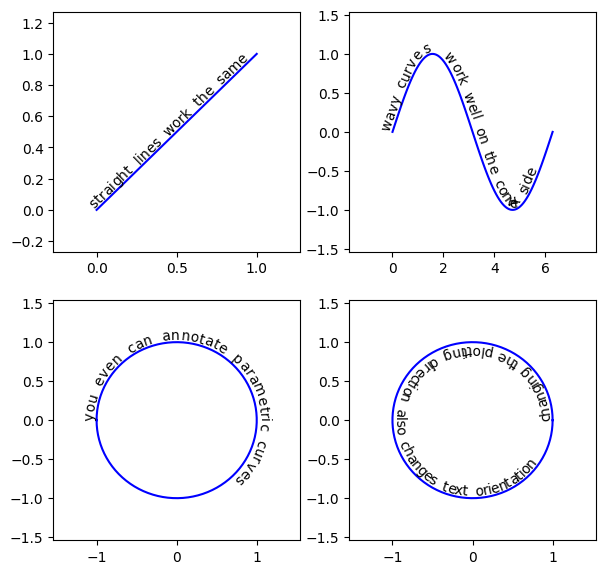

In [2]:
    Figure, Axes = plt.subplots(2,2, figsize=(7,7), dpi=100)


    N = 100

    curves = [
        [
            np.linspace(0,1,N),
            np.linspace(0,1,N),
        ],
        [
            np.linspace(0,2*np.pi,N),
            np.sin(np.linspace(0,2*np.pi,N)),
        ],
        [
            -np.cos(np.linspace(0,2*np.pi,N)),
            np.sin(np.linspace(0,2*np.pi,N)),
        ],
        [
            np.cos(np.linspace(0,2*np.pi,N)),
            np.sin(np.linspace(0,2*np.pi,N)),
        ],
    ]

    texts = [
        'straight lines work the same as rotated text',
        'wavy curves work well on the convex side',
        'you even can annotate parametric curves',
        'changing the plotting direction also changes text orientation',
    ]

    for ax, curve, text in zip(Axes.reshape(-1), curves, texts):
        #plotting the curve
        ax.plot(*curve, color='b')

        #adjusting plot limits
        stretch = 0.2
        xlim = ax.get_xlim()
        w = xlim[1] - xlim[0]
        ax.set_xlim([xlim[0]-stretch*w, xlim[1]+stretch*w])
        ylim = ax.get_ylim()
        h = ylim[1] - ylim[0]
        ax.set_ylim([ylim[0]-stretch*h, ylim[1]+stretch*h])

        #adding the text
        text = CurvedText(
            x = curve[0],
            y = curve[1],
            text=text,#'this this is a very, very long text',
            va = 'bottom',
            axes = ax, ##calls ax.add_artist in __init__
        )
        #break

    plt.show()


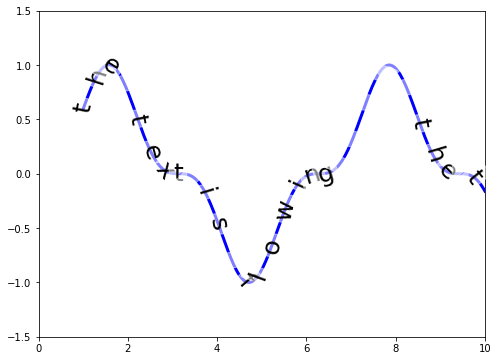

In [6]:
#https://stackoverflow.com/questions/19353576/curved-text-rendering-in-matplotlib
from __future__ import division
import itertools
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# define figure and axes properties
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlim(left=0, right=10)
ax.set_ylim(bottom=-1.5, top=1.5)
(xmin, xmax), (ymin, ymax) = ax.get_xlim(), ax.get_ylim()

# calculate a shape factor, more explanation on usage further
# it is a representation of the distortion of the actual image compared to a 
# cartesian space:
fshape = abs(fig.get_figwidth()*(xmax - xmin)/(ymax - ymin)/fig.get_figheight())

# the text you want to plot along your line
thetext = 'the text is flowing      '

# generate a cycler, so that the string is cycled through
lettercycler = itertools.cycle(tuple(thetext))

# generate dummy river coordinates
xvals = np.linspace(1, 10, 300)
yvals = np.sin(xvals)**3

# every XX datapoints, a character is printed
markerevery = 10

# calculate the rotation angle for the labels (in degrees)
# the angle is calculated as the slope between two datapoints.
# it is then multiplied by a shape factor to get from the angles in a
# cartesian space to the angles in this figure
# first calculate the slope between two consecutive points, multiply with the
# shape factor, get the angle in radians with the arctangens functions, and
# convert to degrees
angles = np.rad2deg(np.arctan((yvals[1:]-yvals[:-1])/(xvals[1:]-xvals[:-1])*fshape))

# plot the 'river'
ax.plot(xvals, yvals, 'b', linewidth=3)

# loop over the data points, but only plot a character every XX steps
for counter in np.arange(0, len(xvals)-1, step=markerevery):
    # plot the character in between two datapoints
    xcoord = (xvals[counter] + xvals[counter+1])/2.
    ycoord = (yvals[counter] + yvals[counter+1])/2.

    # plot using the text method, set the rotation so it follows the line,
    # aling in the center for a nicer look, optionally, a box can be drawn
    # around the letter
    ax.text(xcoord, ycoord, next(lettercycler),
            fontsize=25, rotation=angles[counter],
            horizontalalignment='center', verticalalignment='center',
            bbox=dict(facecolor='white', edgecolor='white', alpha=0.5))


In [27]:
#np.insert(np.cumsum(r_fig_dist),0,0)
np.insert(np.cumsum([1,2,3]),0,0)


array([0, 1, 3, 6])

In [2]:
from scipy import stats

/home/achen/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/achen/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/achen/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [6]:
stats.spearmanr([1,2,3],[1222,22,322])

SpearmanrResult(correlation=-0.5, pvalue=0.6666666666666667)